# make a very simple LSTM model with keras

see how long this will take to run for 7t data with a not too complicated model and what kind of resources we are talking about - single run single subject..

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import StandardScaler
import pandas as pd
import nibabel as nb
import hrf_tools
import hcp_utils as hcp
from analysis import plot_59k_results

import matplotlib.pyplot as plt


/opt/miniconda-latest/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
print(np.__version__)

1.19.5


### load data

In [6]:
subject=100610
feature='rms'
n_movies=4
scaler = StandardScaler()

stim = ['tfMRI_MOVIE1_7T_AP','tfMRI_MOVIE2_7T_PA','tfMRI_MOVIE3_7T_PA','tfMRI_MOVIE4_7T_AP']
stim_feat = ['7T_MOVIE1_CC1_v2', '7T_MOVIE2_HO1_v2', '7T_MOVIE3_CC2_v2', '7T_MOVIE4_HO2_v2']
    
i=0
X = np.load(f'../sourcedata/data/HCP_7T_movie_FIX/features/{stim_feat[i]}_rms.npy')
X.shape#plt.plot(X[0:1000])

(9211, 1)

In [7]:
X  = np.load(f'../sourcedata/data/HCP_7T_movie_FIX/features/{stim_feat[i]}_as_embed.npy')

In [8]:
X.shape

(1918, 1024)

In [9]:
from scipy.signal import resample

In [10]:
X = resample(X, 921, axis=0) #resample to 1hz for now 

In [11]:
X_hrf = hrf_tools.apply_optimal_hrf_10hz(X,1)

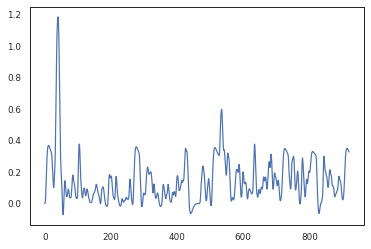

In [12]:
plt.plot(X[:,1])

In [13]:
im_file = f'../sourcedata/data/HCP_7T_movie_FIX/brain/HCP_7T_movie_FIX/100610/MNINonLinear/Results/{stim[i]}/{stim[i]}_Atlas_1.6mm_MSMAll_hp2000_clean.dtseries.nii'
img = nb.load(im_file)
img_y = img.get_fdata()
Y = img_y

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [14]:
#Y is time x brain
Y.shape

(921, 170494)

In [15]:
#X is time x embed
X_hrf.shape

(921, 1024)

### design a simple(?) lstm model

In [16]:
inputs = tf.random.normal([32, 10, 8])
lstm = tf.keras.layers.LSTM(4)
output = lstm(inputs)
print(output.shape)

(32, 4)


In [17]:
model = keras.Sequential(
    [
        layers.Dense(2, activation="relu", name="layer1"),
        layers.Dense(3, activation="relu", name="layer2"),
        layers.Dense(4, name="layer3"),
    ]
)
# Call model on a test input
x = tf.ones((3, 3))
y = model(x)

In [18]:
# Batch size
batch_size = 64
time_steps = 10
input_units = 1024
input_shape = (time_steps,input_units)

model = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
#model.add(layers.Embedding(input_dim=1024, output_dim=1024))
model.add(keras.Input(shape=input_shape))
# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(100))
#model.add(layers.UpSampling1D(size=10))
model.add(layers.Dense(17049))
model.add(layers.Dense(170494))

# Add a Dense layer with 10 units.
#model.add(layers.Dense(1721))

model.summary()

KeyboardInterrupt: 

In [59]:
#dataset = tf.data.Dataset.from_tensor_slices((np.expand_dims(x_train,0), np.expand_dims(y_train,0)))
dataset = tf.data.Dataset.from_tensor_slices((X_hrf, Y))

dataset.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(170494,), dtype=tf.float64, name=None))

In [60]:
#https://keras.io/api/preprocessing/timeseries/
dataset = tf.keras.preprocessing.timeseries_dataset_from_array(data = X_hrf, 
                                                     targets = Y, 
                                                    sequence_length=time_steps,
                                                     batch_size = batch_size)

In [61]:
dataset

<BatchDataset shapes: ((None, None, 1024), (None, 170494)), types: (tf.float32, tf.float64)>

In [62]:


# # Buffer size to shuffle the dataset
# # (TF data is designed to work with possibly infinite sequences,
# # so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# # it maintains a buffer in which it shuffles elements).
# BUFFER_SIZE = 10000

# dataset = (
#     dataset
#     .shuffle(BUFFER_SIZE)
#     .batch(batch_size, drop_remainder=True)
#     .prefetch(tf.data.experimental.AUTOTUNE))

# dataset

In [63]:
#simple_rnn = layers.SimpleRNN(18, return_sequences=True, return_state=True)

In [64]:
#whole_sequence_output, final_state = simple_rnn(np.expand_dims(x_train,0))

In [65]:
model.compile(
    loss=keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
    optimizer="adam",
    metrics=["accuracy", 'mean_squared_error'],
)

In [66]:
model.fit(dataset,epochs = 10)

Epoch 1/10
15/15 [==============================] - 18s 940ms/step - loss: 128136095.0000 - accuracy: 0.0000e+00 - mean_squared_error: 128136095.0000
Epoch 2/10
15/15 [==============================] - 14s 930ms/step - loss: 128109368.5000 - accuracy: 0.0000e+00 - mean_squared_error: 128109368.5000
Epoch 3/10
15/15 [==============================] - 15s 979ms/step - loss: 128066479.0000 - accuracy: 0.0000e+00 - mean_squared_error: 128066479.0000
Epoch 4/10
15/15 [==============================] - 15s 983ms/step - loss: 128024636.0000 - accuracy: 0.0000e+00 - mean_squared_error: 128024636.0000
Epoch 5/10
15/15 [==============================] - 14s 899ms/step - loss: 127984696.5000 - accuracy: 0.0000e+00 - mean_squared_error: 127984696.5000
Epoch 6/10
15/15 [==============================] - 14s 919ms/step - loss: 127946419.0000 - accuracy: 0.0000e+00 - mean_squared_error: 127946419.0000
Epoch 7/10
15/15 [==============================] - 14s 935ms/step - loss: 127909016.0000 - accuracy

KeyboardInterrupt: 

In [163]:
x_test_path = '../data/char_test.npy'
x_test = np.load(x_test_path)
x_test.shape

(198, 9)

In [164]:
y_test_path = '../data/brain_test.npy'
y_test = np.load(y_test_path)
#y_train = y_train[:,0:18]
y_test.shape

(198, 1721)

In [165]:
model.evaluate(x_test,y_test)

7/7 [==============================] - 0s 4ms/step - loss: 0.9385 - accuracy: 0.0000e+00 - mean_squared_error: 0.9385


[0.938504695892334, 0.0, 0.938504695892334]